In [2]:
import pandas as pd
import numpy as np
import hist
import matplotlib as mpl
import mplhep
import mplhep.error_estimation
# mpl.style.use(mplhep.style.ROOT)
import matplotlib.pyplot as plt

In [2]:
pedestals = pd.read_csv('pflib/data/pedestal-2025-07-15-180927.csv')
# define a unique ID for each channel to make histograms a bit easier to make
pedestals['uid'] = pedestals['i_link'].astype(str)+'_'+pedestals['channel']

## Value Ranges
- The TOT is always -1 meaning that no channel ever goes into TOT.
- ADC is between 1 and 63 (inclusive) which is suspicious, **need to double check decoding**
- ADCt-1 is between 129 and 207, also suspicious, **need to double check decoding**
- TOA ranges from 2 to 771

In [3]:
pedestals[['adc','adc_tm1','tot','toa']].max()

adc        255
adc_tm1    255
tot         -1
toa          0
dtype: int64

In [4]:
pedestals[['adc','adc_tm1','tot','toa']].min()

adc        157
adc_tm1    159
tot         -1
toa          0
dtype: int64

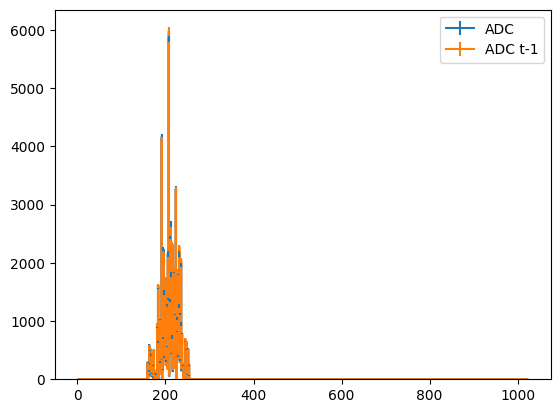

In [5]:
adcmax=1024

(
    hist.Hist.new
    .Reg(adcmax,0,adcmax)
    .Double()
).fill(
    pedestals.adc
).plot(label='ADC')

(
    hist.Hist.new
    .Reg(adcmax,0,adcmax)
    .Double()
).fill(
    pedestals.adc_tm1
).plot(label='ADC t-1')

plt.xlabel(None)
plt.legend()
plt.show()

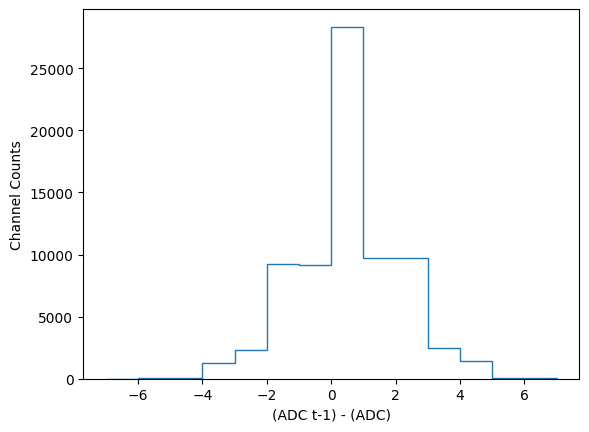

In [6]:
plt.hist(pedestals.adc_tm1-pedestals.adc, bins='auto', histtype='step')
plt.ylabel('Channel Counts')
plt.xlabel('(ADC t-1) - (ADC)')
plt.show()

In [7]:
plt.figure(figsize=(20,10))
(
    hist.Hist.new
    .StrCategory(pedestals['uid'].unique(), label='Link_Channel')
    .Reg(256-64,64,256,label='(ADC t-1)-(ADC)')
    .Double()
).fill(
    pedestals.uid,
    pedestals.adc_tm1-pedestals.adc
).plot2d(
    cmin=1,
    cbarsize=0.7
)
plt.xticks(rotation=90, size='x-small')
plt.show()

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 2000x1000 with 2 Axes>

In [8]:
pedestals.toa.unique()

array([0])

## Pedestal Leveling
https://github.com/LDMX-Software/pflib/pull/182

In [3]:
def load_data(fp):
    d = pd.read_csv(fp)
    d.drop(d[d.channel=='calib'].index, inplace=True)
    d['ch'] = d['i_link']*36+d['channel'].astype(int)
    return d

samples = dict(
    default = load_data('pflib/data/pedestal-2025-07-17-default.csv'),
    leveled = load_data('pflib/data/pedestal-2025-07-17-leveled.csv')
)

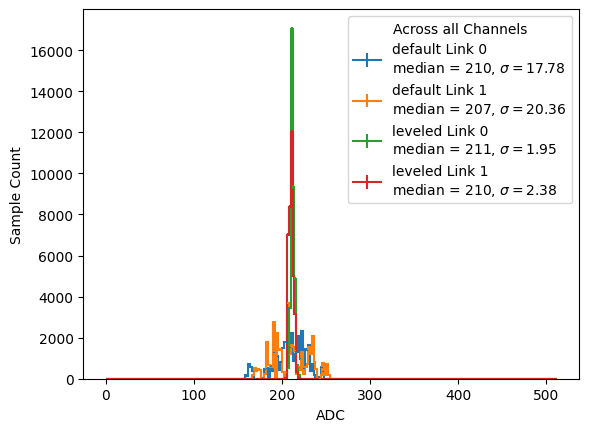

In [4]:
for name, data in samples.items():
    for link in (0,1):
        adc = data[data.i_link==link].adc
        median = adc.median()
        std = adc.std()
        (
            hist.Hist.new
            .Reg(512//2,0,512,label='ADC')
            .Double()
        ).fill(adc).plot(
            label=f'{name} Link {link}\nmedian = {median:.0f}, $\\sigma=${std:.2f}'
        )
plt.ylabel('Sample Count')
plt.legend(title='Across all Channels')
plt.show()

## Distributions

Even though the ranges of these values appear wrong, we can look at the distributions to see if they align with our expectations.

In [3]:
def fill_and_plot_all_channels(
    xname, xlabel, xmin, xmax, rebin=1
):
    plt.figure(figsize=(20,10))
    (
        hist.Hist.new
        .StrCategory(pedestals['uid'].unique(), label='Link_Channel')
        .Reg((xmax-xmin)//rebin,xmin,xmax, label=xlabel)
        .Double()
    ).fill(
        pedestals['uid'],
        pedestals[xname]
    ).plot2d(
        cmin=1,
        cbarsize=0.7
    )
    plt.xticks(rotation=90, size='x-small')
    plt.show()

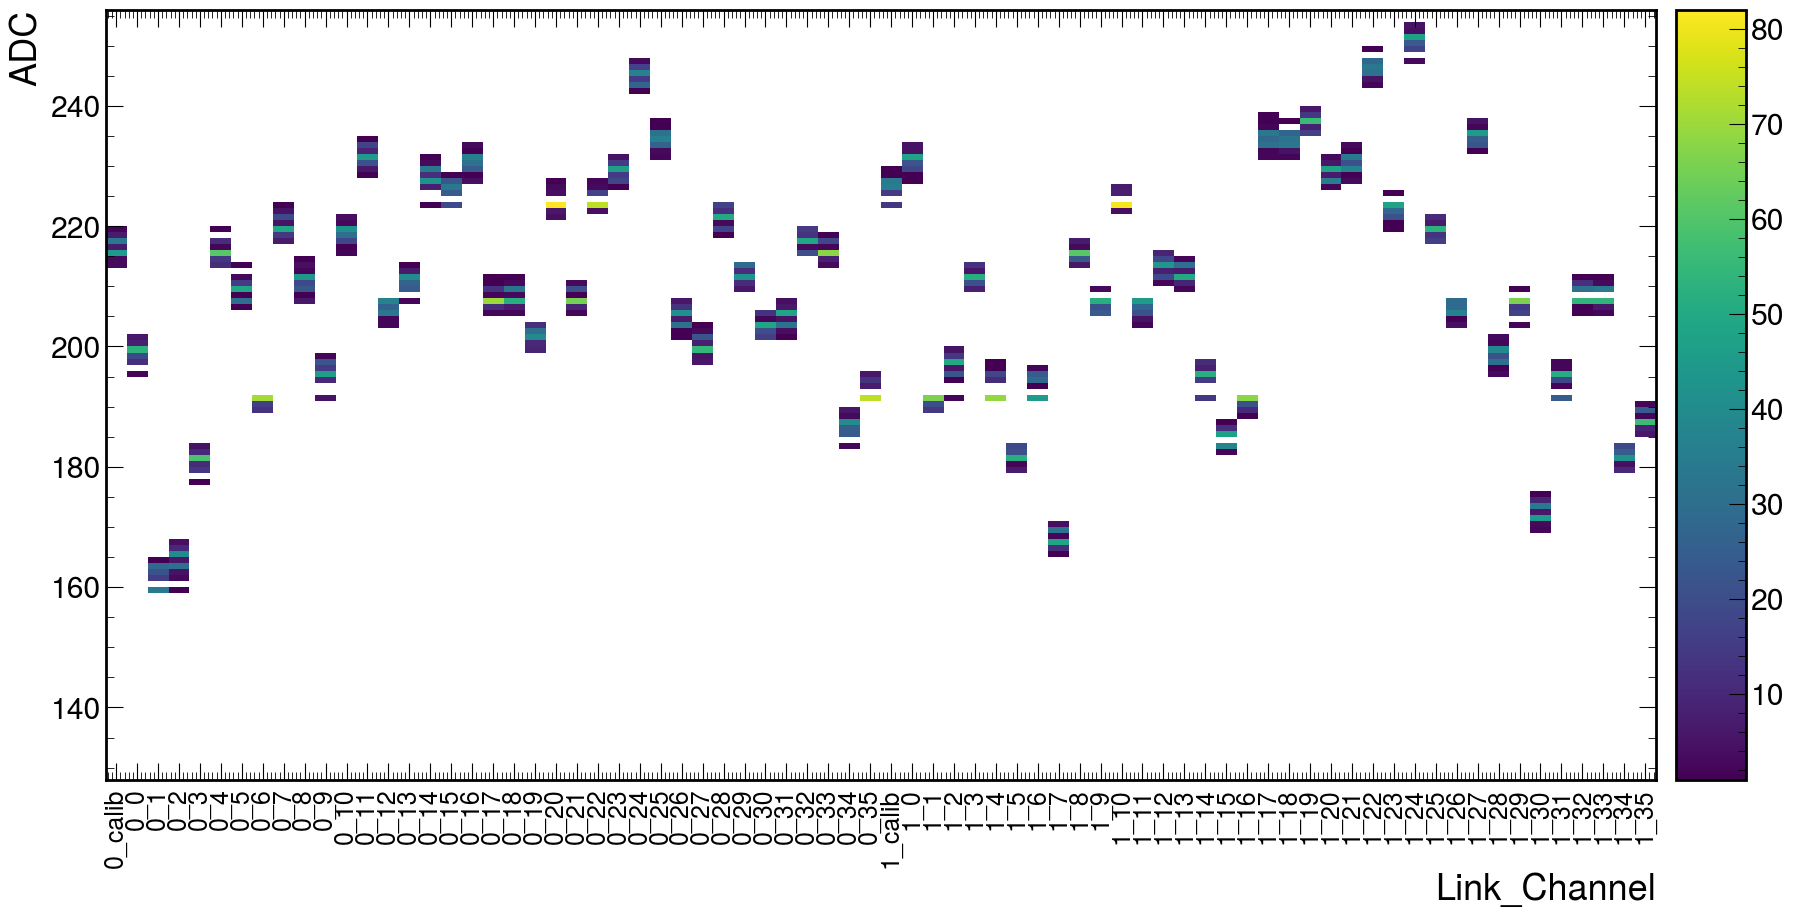

In [12]:
fill_and_plot_all_channels('adc','ADC',128,256)

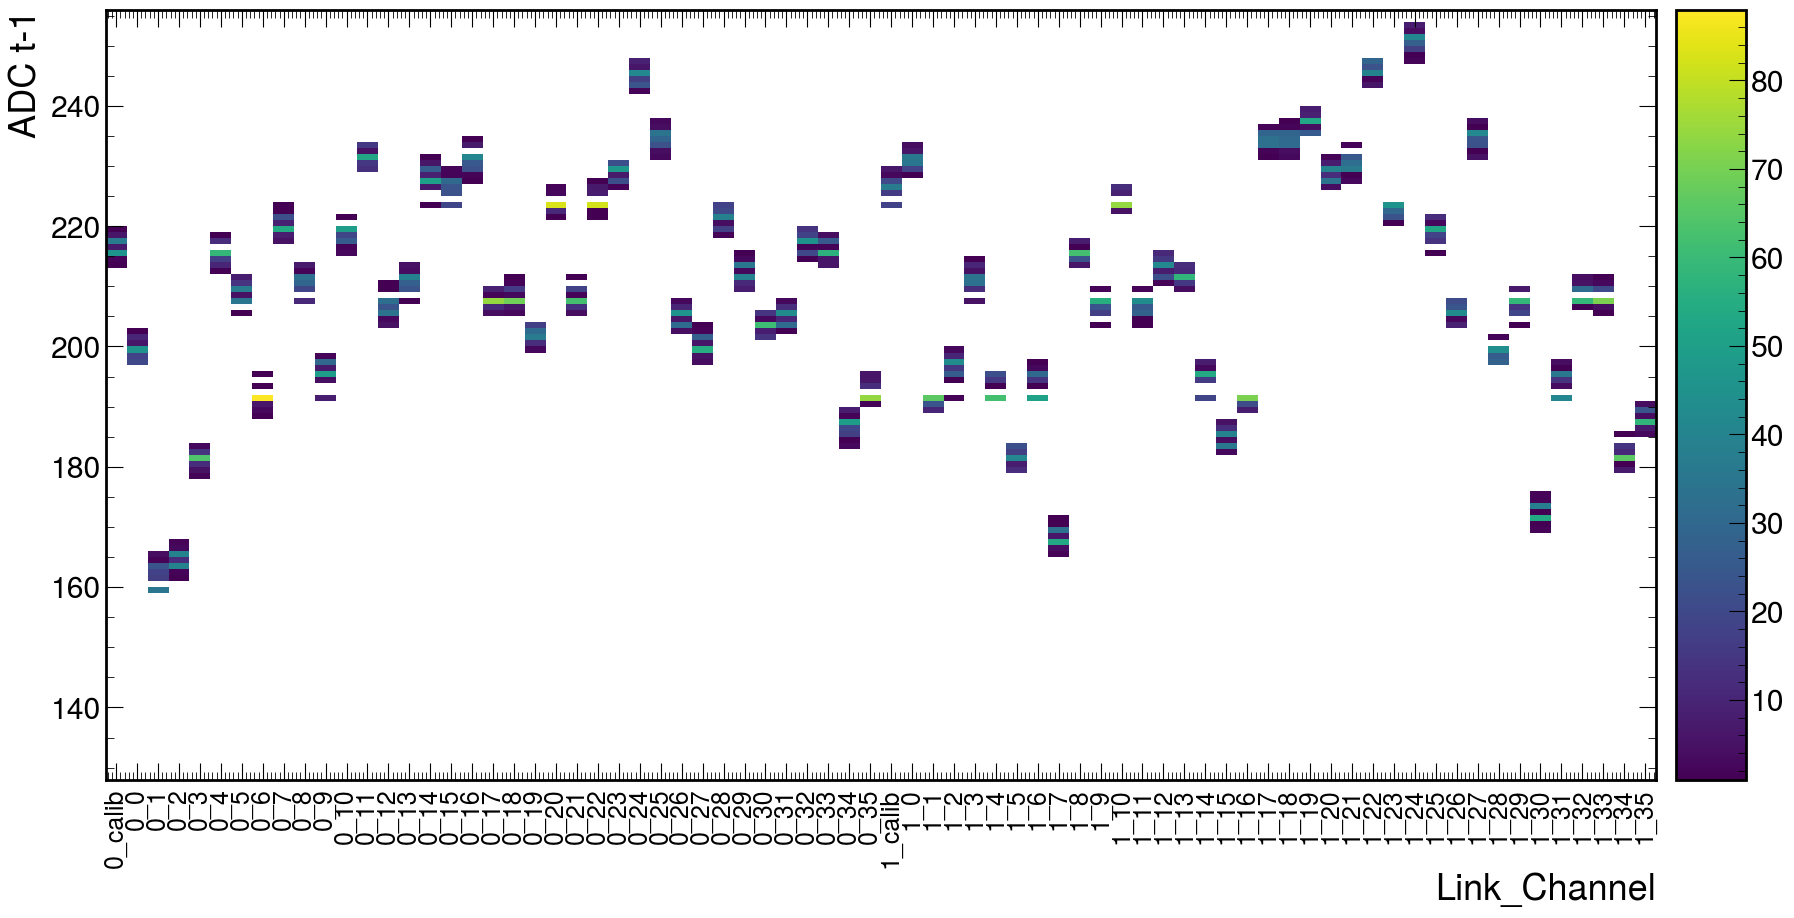

In [13]:
fill_and_plot_all_channels('adc_tm1','ADC t-1',128,256)

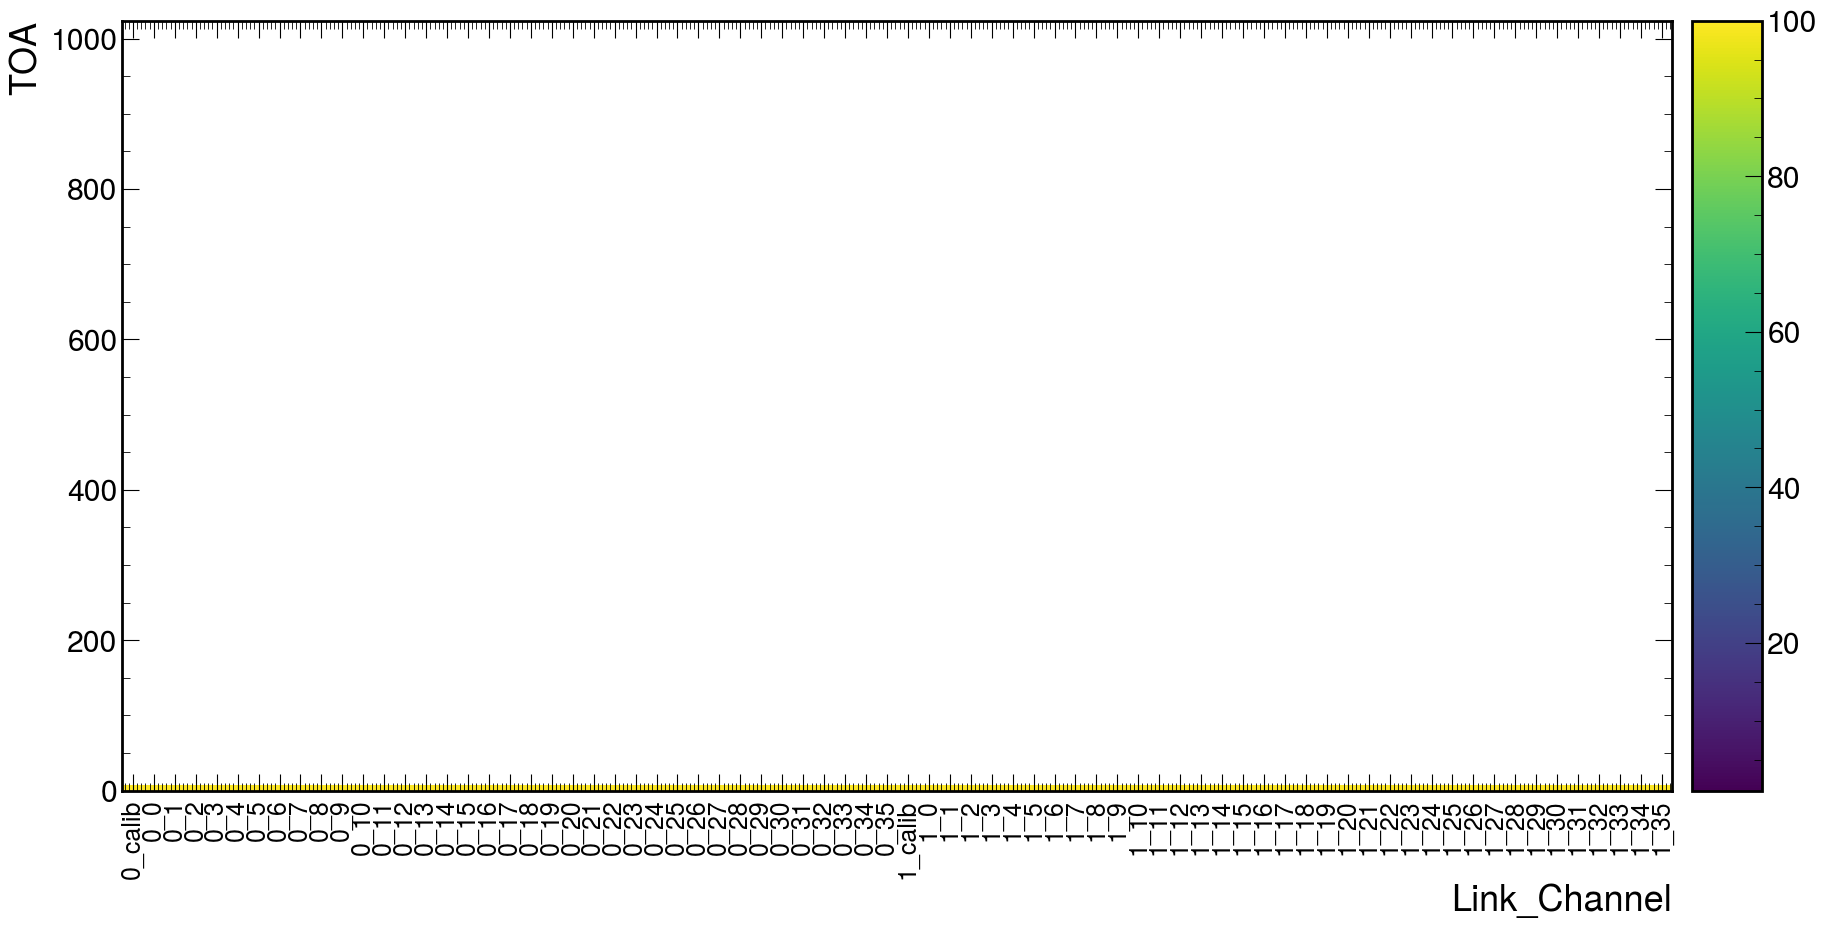

In [14]:
fill_and_plot_all_channels('toa','TOA',0,1024,rebin=8)